# Линейная регрессия и спрямляющее пространство

## Определим необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate
from numpy import sqrt
from scipy import optimize as opt
from numpy.linalg import norm
from numpy.linalg import inv
%matplotlib inline

Данного ноутбука не было в курсе: я решил его сделать по мотивам лекции про спрямляющее пространство, чтобы на практике проверить, что это так и есть. 😁

Пусть решается задача регрессии с одним признаком, отложенным по оси x. По этому признаку требуется
восстановить целевую переменную y. Что делать, если зависимость y от x нелинейна? Перейти к новому признаковому пространству из нескольких признаков вместо одного, в котором можно построить линейная модель. В исходном пространстве эта модель станет нелинейной.

## Определим границы распределения и функции

In [2]:
a, b = 10, 200
count = 30
count_dist = 1000
random = 2000
y_offset = 60000

def plot_dist(x_dots, y_dots, x_line, y_line, title):
    plt.plot(x_dots, y_dots, 'bo', x_line, y_line)
    plt.title(title)

## Создадим основу для "бешеного" распределения

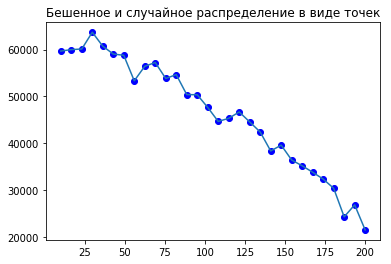

In [3]:
x = np.linspace(a, b, count)
y = -x**2 + np.random.randn(len(x)) * random + y_offset
plot_dist(x, y, x, y, 'Бешенное и случайное распределение в виде точек')

## Создадим функцию распределения для "бешеного" распределения

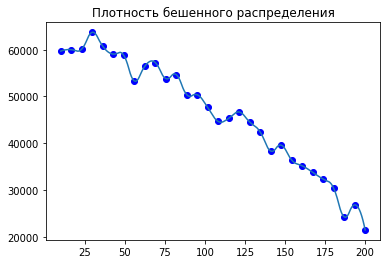

In [4]:
f = interpolate.interp1d(x, y, kind='quadratic')
x_dist = np.linspace(a, b, count_dist)
y_dist = f(x_dist)
plot_dist(x, y, x_dist, y_dist, 'Плотность бешенного распределения')

## Градиентный спуск

Параметры $w_0, w_1, w_2, w_3$ и т.д., по которым минимизируется среднеквадратичная ошибка, можно находить численно с помощью градиентного спуска.
Градиентный шаг для весов будет выглядеть следующим образом:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3} + ...) - y_i)}}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3} + ...) - y_i)}},\ j \in \{1,2,3,...\}$$
Здесь $\eta$ - параметр, шаг градиентного спуска.

### Цикл

In [5]:
def error_cycle(w):
    sum = (((w[0] + w[1] * x + w[2] * x**2) - y)**2).sum()
    return sum

In [6]:
%timeit opt.minimize(error_cycle, (0,0,0)).x
w_cycle = opt.minimize(error_cycle, (0,0,0)).x
print (w_cycle)
y_cycle = w_cycle[0] + w_cycle[1] * x + w_cycle[2] * x**2

8.52 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[ 6.22890514e+04 -5.74708504e+01 -7.00043955e-01]


### Матрицы

In [7]:
x_m = np.matrix(np.asarray([np.full((count_dist,), 1), x_dist, x_dist**2]).transpose())
y_m = np.matrix(np.asarray(y_dist).reshape(count_dist,1))

In [8]:
def error_mat(w_m1):
    return norm(x_m * np.matrix(w_m1.reshape(len(w_m1),1)) - y_m)

In [9]:
%timeit opt.minimize(error_mat, np.matrix(np.asarray((0,0,0)).reshape(x_m.shape[1],1)), method = 'BFGS').x

w_mat = opt.minimize(error_mat, np.matrix(np.asarray((0,0,0)).reshape(x_m.shape[1],1)), method = 'BFGS').x
print(w_mat)
y_mat = x_m * w_mat.reshape(len(w_mat),1)

27.8 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[ 6.28975364e+04 -7.17373608e+01 -6.30810412e-01]


## Аналитическое решение

Нахождение вектора оптимальных весов $w$ может быть сделано и аналитически.
Мы хотим найти такой вектор весов $w$, чтобы вектор $y$, приближающий целевой признак, получался умножением матрицы $X$ (состоящей из всех признаков объектов обучающей выборки, кроме целевого) на вектор весов $w$. То есть, чтобы выполнялось матричное уравнение:
$$\Large y = Xw$$
Домножением слева на $X^T$ получаем:
$$\Large X^Ty = X^TXw$$
Это хорошо, поскольку теперь матрица $X^TX$ - квадратная, и можно найти решение (вектор $w$) в виде:
$$\Large w = {(X^TX)}^{-1}X^Ty$$
Матрица ${(X^TX)}^{-1}X^T$ - [*псевдообратная*](https://ru.wikipedia.org/wiki/Псевдообратная_матрица) для матрицы $X$. В NumPy такую матрицу можно вычислить с помощью функции [numpy.linalg.pinv](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.pinv.html).

Однако, нахождение псевдообратной матрицы - операция вычислительно сложная и нестабильная в случае малого определителя матрицы $X$ (проблема мультиколлинеарности). 
На практике лучше находить вектор весов $w$ решением матричного уравнения 
$$\Large X^TXw = X^Ty$$Это может быть сделано с помощью функции [numpy.linalg.solve](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linalg.solve.html).

Но все же на практике для больших матриц $X$ быстрее работает градиентный спуск, особенно его стохастическая версия.

### Версия 1

In [10]:
%timeit np.linalg.inv(x_m.T * x_m) * x_m.T * y_m

w_an1 = np.linalg.inv(x_m.T * x_m) * x_m.T * y_m
print(w_an1)
y_an1 = x_m * w_an1.reshape(len(w_an1),1)

67.5 µs ± 6.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
[[ 6.28976950e+04]
 [-7.17405136e+01]
 [-6.30797286e-01]]


### Версия 2

In [11]:
%timeit np.linalg.solve(x_m.T * x_m, x_m.T * y_m)

w_an2 = np.linalg.solve(x_m.T * x_m, x_m.T * y_m)
print(w_an2)
y_an2 = x_m * w_an2.reshape(len(w_an2),1)

65.8 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
[[ 6.28976950e+04]
 [-7.17405136e+01]
 [-6.30797286e-01]]


### Версия 3

In [12]:
%timeit np.dot(np.dot(inv(np.dot(x_m.T, x_m)),x_m.T),y_m)

w_an3 = np.dot(np.dot(inv(np.dot(x_m.T, x_m)),x_m.T),y_m)
print(w_an3)
y_an3 = x_m * w_an3.reshape(len(w_an3),1)

45.6 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
[[ 6.28976950e+04]
 [-7.17405136e+01]
 [-6.30797286e-01]]


## Выводим всё на единый график

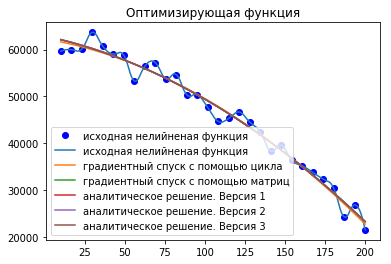

In [13]:
plt.plot(x, y, 'bo', x_dist, y_dist, label = 'исходная нелийненая функция')
plt.plot(x, y_cycle, label = 'градиентный спуск с помощью цикла')
plt.plot(x_dist, y_mat, label = 'градиентный спуск с помощью матриц')
plt.plot(x_dist, y_an1, label = 'аналитическое решение. Версия 1')
plt.plot(x_dist, y_an2, label = 'аналитическое решение. Версия 2')
plt.plot(x_dist, y_an3, label = 'аналитическое решение. Версия 3')
plt.title('Оптимизирующая функция')
plt.legend()
plt.show()

In [15]:
print('Град спуск в цикле', w_cycle)
print('Град спуск с помощью матриц', w_mat)
print('Аналитическое решение. Версия 1', w_an1.ravel())
print('Аналитическое решение. Версия 2', w_an2.ravel())
print('Аналитическое решение. Версия 3', w_an3.ravel())

Град спуск в цикле [ 6.22890514e+04 -5.74708504e+01 -7.00043955e-01]
Град спуск с помощью матриц [ 6.28975364e+04 -7.17373608e+01 -6.30810412e-01]
Аналитическое решение. Версия 1 [[ 6.28976950e+04 -7.17405136e+01 -6.30797286e-01]]
Аналитическое решение. Версия 2 [[ 6.28976950e+04 -7.17405136e+01 -6.30797286e-01]]
Аналитическое решение. Версия 3 [[ 6.28976950e+04 -7.17405136e+01 -6.30797286e-01]]


## Вывод
Если создать новые признаки на основе существующих, то можно обучить линейную модель на этом новом пространстве признаков. На этом пространстве признаков она будет линейной, а на исходном пространстве признаков она уже станет нелинейной. Если исходная зависимость нелинейна, то таким образом её можно решить с помощью *линейной* функции.